In [287]:
import os
import pandas as pd
import numpy as np
import requests
import json
import glob
import re
import seaborn as sns
from matplotlib import pyplot as plt
from monty.serialization import loadfn

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

Select desired values for booleans:

In [288]:
#True if using charge_throughput as response variable, False if using cycle life (X.capacity_0.8)
ct = True

#True if training on old data and testing on new data, False if mixing both old and new data into train and test set
#Only applies to when old and new data are combined
train_old_test_new = False

#True if including 'X.integrated_time_temperature_cycles_1:100' to full model, False if not
integrated_time_temp_cycles = False

#True if applying a log transformtion to combined data, False if no transformation
log_transformation = False

#True if including internal resistance for old data, False if not (no internal resistance variable for new data)
ir = False

#True if standardizing explanatory variables, False otherwise (necessary for elastic net)
standardized = False

#True if using old and new data scaled separately in combined data, False if using a separate standard scaler for all combined data
old_new_scaler = False

#True if using all battery chemistries, False if only LFP
new_chemistries = True

#True if identifying the source of the data (old, LFP, NCA, NMC), False if not
sources = True

#True if reading in the old data correctly, False if mistakenly. 
#The only reason to set this to false is if you're recreating incorrect plots to illustrate the change
proper_old_reading = True

## Reading in the Data

In [289]:
path = "../"

if proper_old_reading:
    old_subpath = "FastCharge/data-share/features/"

    old_d_dir = path + old_subpath + "DeltaQFastCharge"
    old_t_dir = path + old_subpath + "TrajectoryFastCharge"


    def getListOfFiles(dirName):
        listOfFile = os.listdir(dirName)
        allFiles = list()
        for entry in listOfFile:
            fullPath = os.path.join(dirName, entry)
            if ".json" in fullPath:
                allFiles.append(fullPath)
        return allFiles

    old_d_list = getListOfFiles(old_d_dir)
    old_t_list = getListOfFiles(old_t_dir)

In [290]:
if proper_old_reading:
    def get_new_names(d_list):
        new_names = []
        for file in d_list:
            new_names.append(re.findall("CH(.*?)\_f", file)[0])
        return new_names

    def make_df(file_list, batch=False):
        df = pd.DataFrame()
        for file in file_list:
            with open(file) as data_file:    
                data = json.load(data_file)
                data_df = pd.json_normalize(data)
                df = pd.concat([df,data_df])
        df.reset_index(drop=True,inplace=True)
        if batch:
            df['bat_num'] = get_new_names(file_list)
        return df

    def merge_df(d_df, t_df):
        df_full = d_df.merge(t_df, left_index=True, right_index=True)

        # Making values not stored as lists
        for column in df_full.columns:
            if "X." in column:
                df_full[column] = df_full[column].apply(lambda x: x[0])

        df_full.reset_index(inplace=True)
        return df_full

In [291]:
if proper_old_reading:
    old_d_df = make_df(old_d_list, batch=True)
    old_d_df.head()

    batches = []
    for i in old_d_df['metadata.protocol']:
        if '2017-05' in i:
            batches.append('b1')
        elif '2017-06' in i:
            batches.append('b2')
        elif '2018-04' in i:
            batches.append('b3')

    old_d_df['batches'] = batches
    old_d_df['bat_name'] = old_d_df['batches'] + 'c' + old_d_df['bat_num']

In [292]:
if proper_old_reading:
    old_t_df = make_df(old_t_list)
    old_t_df.head()

In [293]:
if proper_old_reading:
    old_df_full = merge_df(old_d_df, old_t_df)
    old_df_full.sort_values(by=['bat_name'],inplace=True)
    old_df_full.head()

In [294]:
old_ct = pd.read_csv("./OldData/OldDataFullCT.csv")

In [295]:
old_ct.rename(columns={"Unnamed: 0": "ind"},inplace=True)

In [296]:
old_df_full.rename(columns={"index": "ind"},inplace = True)

In [297]:
if proper_old_reading:
    old_ct = old_ct.filter(["ind", "charge_throughput"])
    old_ct = old_df_full.merge(old_ct, on="ind", how="left")

In [298]:
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [299]:
new_ct = pd.read_csv("NewData/charge_throughputs_BA.csv")

if new_chemistries:
    nca_df = pd.read_csv("NewData/charge_throughputs_BA_NCA.csv")
    nmc_df = pd.read_csv("NewData/charge_throughputs_BA_NMC.csv")
    
    chemistries = ["LFP", "NCA", "NMC"]
    dfs = [new_ct, nca_df, nmc_df]
    
    for i in range(len(chemistries)):
        chem = chemistries[i]
        for j in range(len(dfs)):
            df = dfs[j]
            
            if i == j:
                df[chem] = 1
            else:
                df[chem] = -1
            
            dfs[j] = df
        
    new_ct = pd.concat([df for df in dfs], ignore_index=True)

In [300]:
variance_model_features = ['X.abs_variance_discharge_capacity_difference_cycles_2:100']
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5']

if integrated_time_temp_cycles:
    full_model_features.append('X.integrated_time_temperature_cycles_1:100')

if ir:
    full_model_features.append('X.min_internal_resistance_cycles_2:100')
    full_model_features.append('X.internal_resistance_difference_cycles_2:100')

if ct:
    y = 'charge_throughput'
else:
    y = 'cycle_index'

In [301]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

## Old Data

<AxesSubplot:xlabel='X.abs_variance_discharge_capacity_difference_cycles_2:100', ylabel='charge_throughput'>

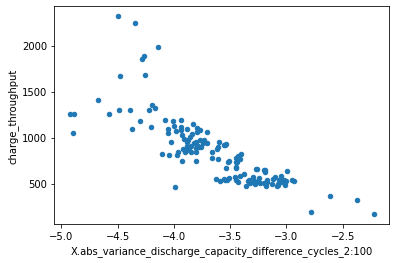

In [302]:
old_ct.plot.scatter(x='X.abs_variance_discharge_capacity_difference_cycles_2:100', y = y)

#### Our split (odds to train, evens to test):

In [303]:
# train_ind = [i for i in range(1, len(old_ct), 2)]
# test_ind = [i for i in range(0, len(old_ct), 2)]

In [304]:
len(old_ct)

139

#### TRI Split:

In [305]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]

In [306]:
if standardized:
    
    all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features))
    
    def standardize(train, test):
        scaler = StandardScaler()
        scaler.fit(train)
        train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
        test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
        return [train_data, test_data]

In [307]:
if old_new_scaler:
    X_train_all_old = old_ct.iloc[train_ind][all_model_features]
    X_test_all_old = old_ct.iloc[test_ind][all_model_features]

    X_train_all_old, X_test_all_old = standardize(X_train_all_old, X_test_all_old)

    X_train_all_old["charge_throughput"] = old_ct.iloc[train_ind]["charge_throughput"]
    X_test_all_old["charge_throughput"] = old_ct.iloc[test_ind]["charge_throughput"]

    X_all_old = X_train_all_old.append(X_test_all_old)

### Variance Model

In [308]:
# Variance model
X_train_var = old_ct.iloc[train_ind][variance_model_features]

y_train = old_ct.iloc[train_ind][[y]]

X_test_var = old_ct.iloc[test_ind][variance_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if standardized:
    X_train_var, X_test_var = standardize(X_train_var, X_test_var)

In [309]:
reg_var = RandomForestRegressor(criterion='mae').fit(X_train_var, np.ravel(y_train))

y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Random Forest Model")
# print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
# print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Random Forest Model
Test RMSE:  159.15464037997847
Mean % Test Error:  16.749879527349435


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

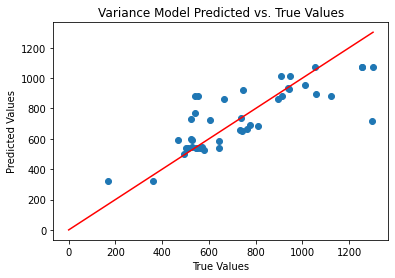

In [310]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

#### From paper (Variance Model)
* Training RMSE: 103
* Test RMSE: 138
* Mean % Train Error: 14.1
* Mean % Test Error: 14.7

### Discharge Model

In [311]:
# discharge model
X_train_dis = old_ct.iloc[train_ind][discharge_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_dis = old_ct.iloc[test_ind][discharge_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if standardized:
    X_train_dis, X_test_dis = standardize(X_train_dis, X_test_dis)

reg_dis = RandomForestRegressor(criterion='mae').fit(X_train_dis,np.ravel(y_train))
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Random Forest Model")
# print("Training RMSE: ", rmse_train_dis)
print("Test RMSE: ", rmse_test_dis)
# print("Train Mean % Error: ", mape_train_dis)
print("Test Mean % Error: ", mape_test_dis)

Discharge Random Forest Model
Test RMSE:  115.05302523268823
Test Mean % Error:  13.735997282536113


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

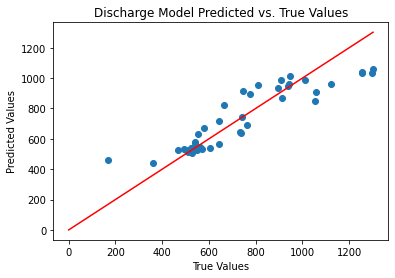

In [312]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

#### From paper (Discharge Model)
* Training RMSE: 76
* Test RMSE: 91
* Mean % Train Error: 9.8
* Mean % Test Error: 13.0

### Full Model

In [313]:
# full model
X_train_full = old_ct.iloc[train_ind][full_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_full = old_ct.iloc[test_ind][full_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if standardized:
    X_train_full, X_test_full = standardize(X_train_full, X_test_full)

reg_full = RandomForestRegressor(criterion='mae').fit(X_train_full,np.ravel(y_train))
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Random Forest Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", rmse_test_full)
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mape_test_full)

Full Random Forest Model
Test RMSE:  106.06016733934408
Mean % Test Error:  13.68172914606296


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

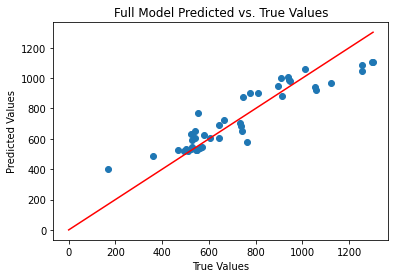

In [314]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

#### From paper (Full Model)
* Training RMSE: 51
* Test RMSE: 118
* Mean % Train Error: 5.6
* Mean % Test Error: 14.1

### Old Data Plots

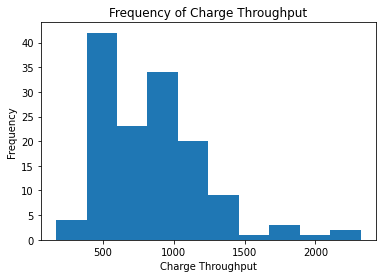

In [315]:
plt.hist(old_ct[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life')

In [316]:
old_data_metrics = pd.DataFrame(data = {
    
                               "Model": ["Variance",
                                         "Discharge",
                                         "Full"],
                                        
                               "Test MAPE": [mape_test_var,
                                              mape_test_dis,
                                              mape_test_full],
                               
                               "Test RMSE": [rmse_test_var,
                                             rmse_test_dis,
                                             rmse_test_full]})#,

Text(0.5, 1.0, 'Old Data Test RMSE Comparison')

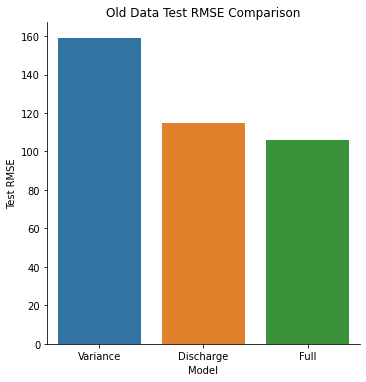

In [317]:
sns.catplot(data = old_data_metrics, kind="bar",
               x = "Model", y = "Test RMSE")
plt.title("Old Data Test RMSE Comparison")

Text(0.5, 1.0, 'Old Data Test MAPE Comparison')

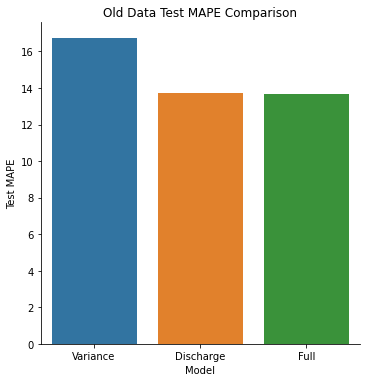

In [318]:
sns.catplot(data = old_data_metrics, kind="bar",
               x = "Model", y = "Test MAPE")
plt.title("Old Data Test MAPE Comparison")

In [319]:
#Removing internal_resistance features for models with new data
if ir:
    full_model_features.remove('X.min_internal_resistance_cycles_2:100')
    full_model_features.remove('X.internal_resistance_difference_cycles_2:100')
    
    if standardized:
        all_model_features.remove('X.min_internal_resistance_cycles_2:100')
        all_model_features.remove('X.internal_resistance_difference_cycles_2:100')

## New Data

In [320]:
new_df = pd.read_csv("NewData/LFPBatteries.csv")

if new_chemistries:
    nca = pd.read_csv("NewData/NCABatteries.csv")
    nmc = pd.read_csv("NewData/NMCBatteries.csv")
    
    new_df = pd.concat([new_df, nca, nmc], ignore_index=True)
    
    if sources:    
        chemistries = ["X.LFP", "X.NCA", "X.NMC"]

        variance_model_features = variance_model_features + chemistries
        discharge_model_features = discharge_model_features + chemistries
        full_model_features = full_model_features + chemistries

In [321]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, left_index = True, right_index=True)
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [322]:
train_ind = [i for i in range(1, len(new_ct_full), 2)]
test_ind = [i for i in range(0, len(new_ct_full), 2)]

In [323]:
if old_new_scaler:
    all_model_features = all_model_features + chemistries
    X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf], np.nan)
    X_train_all_new.dropna(axis=0, inplace=True)
    X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf], np.nan)
    X_test_all_new.dropna(axis=0, inplace=True)

    X_train_all_new, X_test_all_new = standardize(X_train_all_new, X_test_all_new)

    X_train_all_new["charge_throughput"] = new_ct_full.iloc[train_ind]["charge_throughput"]
    X_test_all_new["charge_throughput"] = new_ct_full.iloc[test_ind]["charge_throughput"]

    X_all_new = X_train_all_new.append(X_test_all_new)

### Variance Model

In [324]:
# Variance model
X_train_var = new_ct_full.iloc[train_ind][variance_model_features]
X_train_var.dropna(axis=0, inplace=True)
y_train = new_ct_full.iloc[X_train_var.index][[y]]

X_test_var = new_ct_full.iloc[test_ind][variance_model_features]
X_test_var.dropna(axis=0, inplace=True)
y_test = new_ct_full.iloc[X_test_var.index][[y]]

if standardized:
    X_train_var, X_test_var = standardize(X_train_var, X_test_var)

In [325]:
reg_var = RandomForestRegressor(criterion='mae').fit(X_train_var, np.ravel(y_train))
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Random Forest Model")
# print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
# print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Random Forest Model
Test RMSE:  1437.6122998666092
Mean % Test Error:  33.63757293776185


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (LR)')

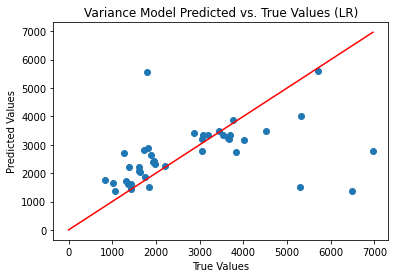

In [326]:
# Linear Regression
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (LR)")

### Discharge Model

In [327]:
# discharge model
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf], np.nan)
X_train_dis.dropna(axis=0, inplace=True)
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf], np.nan)
X_test_dis.dropna(axis=0, inplace=True)
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

if standardized:
    X_train_dis, X_test_dis = standardize(X_train_dis, X_test_dis)

reg_dis = RandomForestRegressor(criterion='mae').fit(X_train_dis, np.ravel(y_train))
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Random Forest Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", rmse_test_dis)
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mape_test_dis)

Discharge Random Forest Model
Test RMSE:  973.1115168215617
Mean % Test Error:  32.57237540143013


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR)')

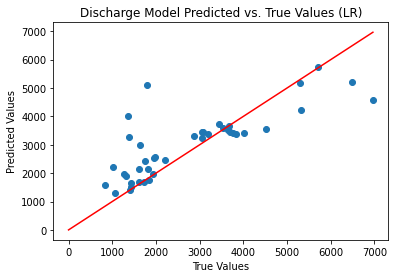

In [328]:
# Linear Regression
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR)")

### Full Model

In [329]:
# full model
X_train_full = new_ct_full.iloc[train_ind][full_model_features].replace([np.inf, -np.inf], np.nan)
X_train_full.dropna(axis=0, inplace=True) 
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features].replace([np.inf, -np.inf], np.nan)
X_test_full.dropna(axis=0, inplace=True) 
y_test = new_ct_full.iloc[X_test_full.index][[y]]

if standardized:
    X_train_full, X_test_full = standardize(X_train_full, X_test_full)

reg_full = RandomForestRegressor(criterion='mae').fit(X_train_full, np.ravel(y_train))
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Random Forest Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", rmse_test_full)
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mape_test_full)

Full Random Forest Model
Test RMSE:  1084.72098341559
Mean % Test Error:  25.829581573153952


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (LR)')

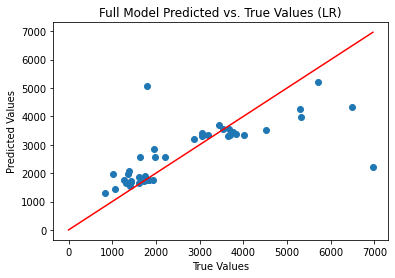

In [330]:
#Linear Regression
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (LR)")

### New Data Plots

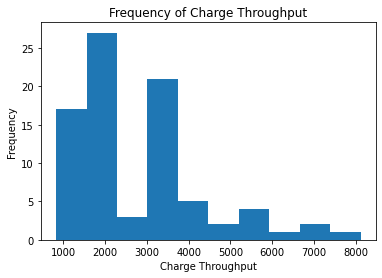

In [331]:
plt.hist(new_ct_full[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life (New Data)')

In [332]:
new_data_metrics = pd.DataFrame(data = {
    
                               "Model": ["Variance",
                                         "Discharge",
                                         "Full"],
                                        
                               "Test MAPE": [mape_test_var,
                                              mape_test_dis,
                                              mape_test_full],
                               
                               "Test RMSE": [rmse_test_var,
                                             rmse_test_dis,
                                             rmse_test_full]})#,

Text(0.5, 1.0, 'New Data Test RMSE Comparison')

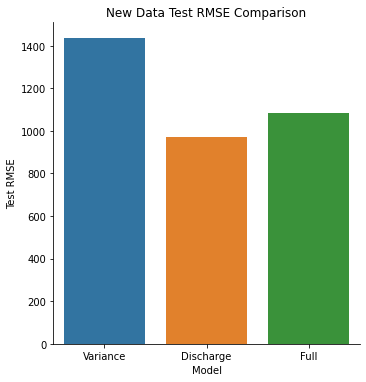

In [333]:
sns.catplot(data = new_data_metrics, kind="bar",
               x = "Model", y = "Test RMSE")
plt.title("New Data Test RMSE Comparison")

Text(0.5, 1.0, 'New Data Test MAPE Comparison')

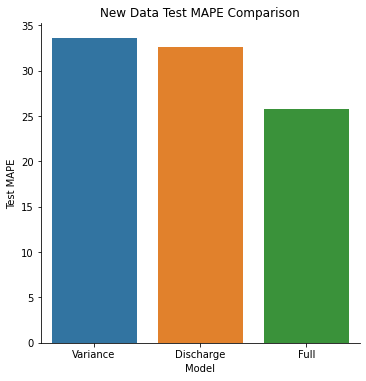

In [334]:
sns.catplot(data = new_data_metrics, kind="bar",
               x = "Model", y = "Test MAPE")
plt.title("New Data Test MAPE Comparison")

## New + Old Data

In [335]:
if sources:
    old_ct["Source"] = -1
    new_ct_full["Source"] = 1

    if new_chemistries:
        for chem in chemistries:
            old_ct[chem] = -1

    variance_model_features.append("Source")
    discharge_model_features.append("Source")
    full_model_features.append("Source")

In [336]:
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

In [337]:
if old_new_scaler:
    X_all_old["Source"] = -1
    X_all_new["Source"] = 1
    for chem in chemistries:
        X_all_old[chem] = -1

    all_model_features.append("Source")

    full_data = X_all_old.append(X_all_new)
    full_data = full_data.reset_index()

In [338]:
if train_old_test_new:
    train_ind = [i for i in range(len(old_ct))]
    test_ind = [j for j in range(len(old_ct),len(full_data))]
    
else:
    train_ind = [i for i in range(1, len(full_data), 2)]
    test_ind = [i for i in range(0, len(full_data), 2)]

### Variance Model

In [339]:
# Variance model
X_train_var = full_data.iloc[train_ind][variance_model_features]
X_train_var.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_var.index][[y]]

X_test_var = full_data.iloc[test_ind][variance_model_features]
X_test_var.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_var.index][[y]]

# if standardized:
#     X_train_var, X_test_var = standardize(X_train_var, X_test_var)

# log transformation
if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [340]:
reg_var = RandomForestRegressor(criterion='mae').fit(X_train_var, np.ravel(y_train))
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_var = np.exp(y_pred_train_var)
    y_pred_test_var = np.exp(y_pred_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Basic Linear Regression Model")
# print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
# print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Test RMSE:  977.9865719436475
Mean % Test Error:  27.86271831069498


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

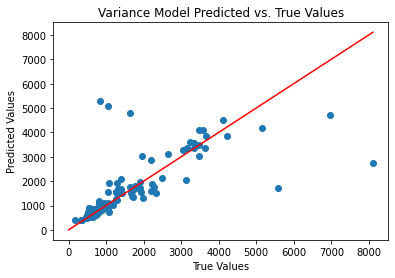

In [341]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

### Discharge Model

In [342]:
# discharge model
X_train_dis = full_data.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_train_dis.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_dis.index][[y]]

X_test_dis = full_data.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_test_dis.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_dis.index][[y]]

# if standardized:
#     X_train_dis, X_test_dis = standardize(X_train_dis, X_test_dis)
    
if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)
    
reg_dis = RandomForestRegressor(criterion='mae').fit(X_train_dis, np.ravel(y_train))
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_dis = np.exp(y_pred_train_dis)
    y_pred_test_dis = np.exp(y_pred_test_dis)
    
rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", rmse_test_dis)
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mape_test_dis)

Discharge Basic Linear Regression Model
Test RMSE:  592.8275756339937
Mean % Test Error:  20.632615113403276


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

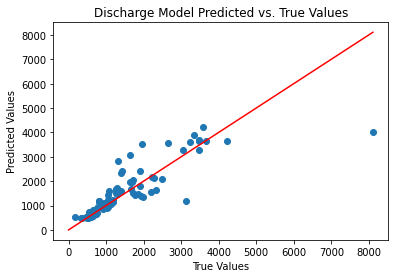

In [343]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

### Full Model

In [344]:
# full model
X_train_full = full_data.iloc[train_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_train_full.dropna(axis=0, inplace=True)
y_train = full_data.loc[X_train_full.index][[y]]

X_test_full = full_data.iloc[test_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_test_full.dropna(axis=0, inplace=True)
y_test = full_data.loc[X_test_full.index][[y]]

# if standardized:
#     X_train_full, X_test_full = standardize(X_train_full, X_test_full)

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

reg_full = RandomForestRegressor(criterion='mae').fit(X_train_full, np.ravel(y_train))
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_full = np.exp(y_pred_train_full)
    y_pred_test_full = np.exp(y_pred_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", rmse_test_full)
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mape_train_full)

Full Basic Linear Regression Model
Test RMSE:  675.3999769122585
Mean % Test Error:  9.87063841404066


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

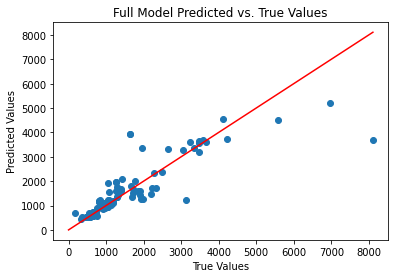

In [345]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

## Old + New Data Plots

/home/steven/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


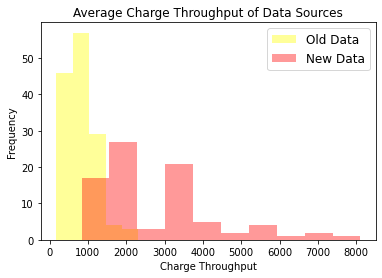

In [346]:
sns.distplot(old_ct[y], kde=False, color="yellow", label='Old Data', bins=5)
sns.distplot(new_ct_full[y], kde=False, color="red", label='New Data', bins=10)

# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

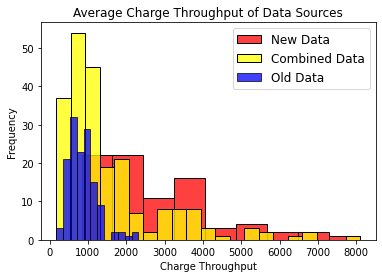

In [347]:
sns.histplot(new_ct_full[y], color="red", label='New Data')
sns.histplot(full_data[y], color = "yellow", label = 'Combined Data')
sns.histplot(old_ct[y], color="blue", label='Old Data')


# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

In [348]:
all_data_metrics = pd.DataFrame(data = {
    
                               "Model": ["Variance",
                                         "Discharge",
                                         "Full"],
                                        
                               "Test MAPE": [mape_test_var,
                                              mape_test_dis,
                                              mape_test_full],
                               
                               "Test RMSE": [rmse_test_var,
                                             rmse_test_dis,
                                             rmse_test_full]})#,

Text(0.5, 1.0, 'Combined Data Test RMSE Comparison')

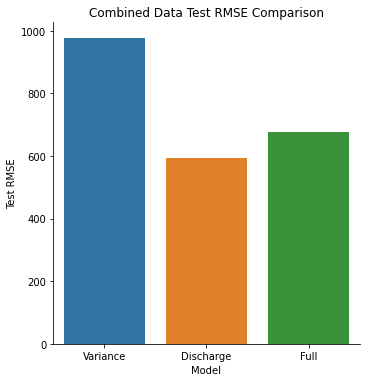

In [349]:
sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = "Test RMSE")
plt.title("Combined Data Test RMSE Comparison")

Text(0.5, 1.0, 'Combined Data Test MAPE Comparison')

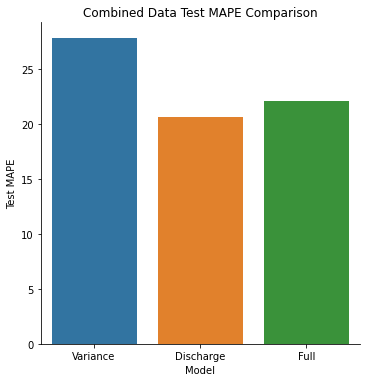

In [350]:
sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = "Test MAPE")
plt.title("Combined Data Test MAPE Comparison")

In [351]:
all_data_metrics['Data'] = 'Combined'
new_data_metrics['Data'] = 'New'
old_data_metrics['Data'] = 'Old'

In [352]:
entire_data_metrics = pd.concat([old_data_metrics,new_data_metrics,all_data_metrics]).reset_index()

(0.0, 85.0)

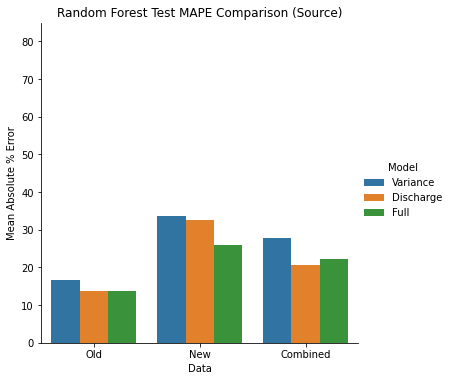

In [355]:
sns.catplot(data = entire_data_metrics, kind="bar",
               x = "Data", y = "Test MAPE",hue = 'Model')
plt.title("Random Forest Test MAPE Comparison (Source)")
plt.ylabel("Mean Absolute % Error")
plt.ylim(0, 85)